# Определение возраста покупателей

## Исследовательский анализ данных

In [32]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
sns.set_style('whitegrid')

In [33]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [34]:
labels.sample(10, random_state = 13)

,file_name,real_age
3579,003579.jpg,22
4132,004132.jpg,26
2285,002285.jpg,50
6993,007004.jpg,27
2651,002651.jpg,4
5178,005178.jpg,30
4395,004395.jpg,1
3377,003377.jpg,13
4981,004981.jpg,33
105,000105.jpg,60


### Посмотрите на размер выборки.

In [35]:
print('Выборка содержит {} строк, {} столбцов'.format(*labels.shape))

Выборка содержит 7591 строк, 2 столбцов


* объем данных маловат для обучения нейросетей, стоит применить аугментацию

### Постройте график распределения возраста в выборке.

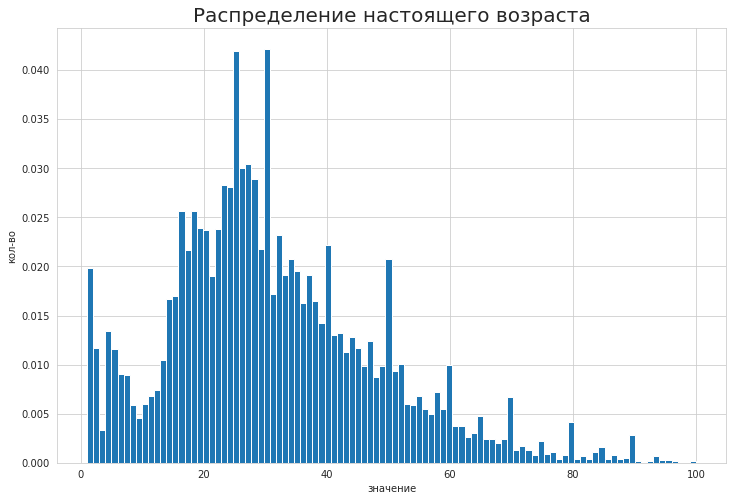

In [36]:
labels['real_age'].hist(bins= 100, figsize = (12, 8), density=1)
plt.title('Распределение настоящего возраста', fontsize = 20)
plt.xlabel('значение')
plt.ylabel('кол-во');

* распределение скошено влево
* наблюдаются пики каждые 10 лет(может быть возраст людей на некоторых фото округлялся или данные фото были размечены вручную по десяткам лет)

### Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.

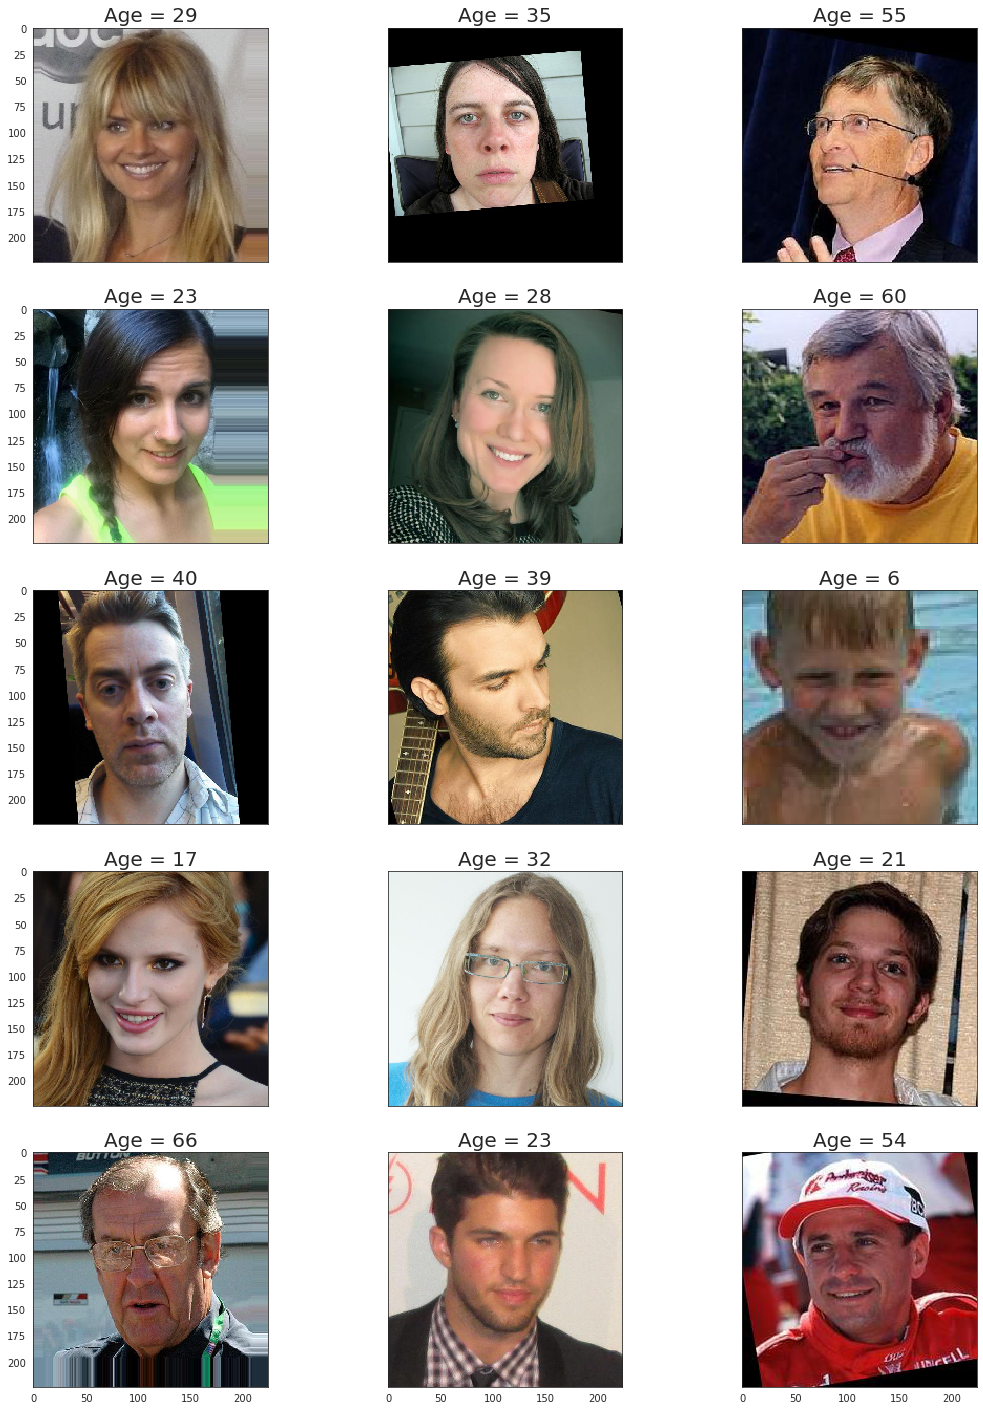

In [31]:
x,y  = train_gen_flow.next()

fig, axes = plt.subplots(ncols=3,nrows=5, sharex=True, sharey=True, figsize=(18,25))

for i, ax in enumerate(axes.flat):
    ax.imshow(x[i], interpolation='none')
    ax.set_title('Age = {}'.format(y[i]), fontsize = 20)
    plt.grid(False)    
plt.show()

* в датасете присутствуют как чб, так и цветные фотографии
* некоторые фотографии являются снимками экрана (это ухудшает качество, изменяет наклон, размер фото)
* отношение размера лица к размеру фото примерно одинаковое
* угол поворота различный (можно добавить флипы)

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```



```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-04-24 05:37:55.095073: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-24 05:37:55.463668: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 104s - loss: 204.0365 - mae: 10.8571 - val_loss: 376.1148 - val_mae: 14.4950
Epoch 2/20
356/356 - 45s - loss: 135.8642 - mae: 8.9640 - val_loss: 285.6626 - val_mae: 12.6400
Epoch 3/20
356/356 - 45s - loss: 107.3782 - mae: 7.9452 - val_loss: 174.6713 - val_mae: 10.5640
Epoch 4/20
356/356 - 44s - loss: 94.9511 - mae: 7.4358 - val_loss: 98.7477 - val_mae: 7.6403
Epoch 5/20
356/356 - 45s - loss: 80.8073 - mae: 6.8800 - val_loss: 122.2891 - val_mae: 8.5459
Epoch 6/20
356/356 - 44s - loss: 65.4083 - mae: 6.2373 - val_loss: 102.4570 - val_mae: 7.5719
Epoch 7/20
356/356 - 44s - loss: 51.7586 - mae: 5.5588 - val_loss: 153.9341 - val_mae: 9.1687
Epoch 8/20
356/356 - 44s - loss: 50.1169 - mae: 5.4548 - val_loss: 100.9669 - val_mae: 7.4993
Epoch 9/20
356/356 - 45s - loss: 46.0887 - mae: 5.2249 - val_loss: 97.0702 - val_mae: 7.5337
Epoch 10/20
356/356 - 45s - loss: 38.3892 - mae: 4.7865 - val_loss: 110.5356 - val_mae: 7.7876
Epoch 11/20
356/356 - 45s - loss: 32.9739 - mae: 4.4393 - val_loss: 86.6724 - val_mae: 7.0004
Epoch 12/20
356/356 - 44s - loss: 26.2281 - mae: 3.9491 - val_loss: 88.5480 - val_mae: 7.1087
Epoch 13/20
356/356 - 44s - loss: 23.1691 - mae: 3.7036 - val_loss: 100.9410 - val_mae: 7.4133
Epoch 14/20
356/356 - 44s - loss: 23.3487 - mae: 3.7042 - val_loss: 82.9609 - val_mae: 6.8077
Epoch 15/20
356/356 - 45s - loss: 22.7440 - mae: 3.6867 - val_loss: 86.9023 - val_mae: 7.2506
Epoch 16/20
356/356 - 44s - loss: 18.1749 - mae: 3.2941 - val_loss: 96.5892 - val_mae: 7.6231
Epoch 17/20
356/356 - 44s - loss: 19.6312 - mae: 3.4004 - val_loss: 84.7317 - val_mae: 6.9245
Epoch 18/20
356/356 - 44s - loss: 22.3769 - mae: 3.6195 - val_loss: 108.0828 - val_mae: 7.7115
Epoch 19/20
356/356 - 45s - loss: 21.5409 - mae: 3.5835 - val_loss: 97.5275 - val_mae: 7.1799
Epoch 20/20
356/356 - 44s - loss: 18.3244 - mae: 3.2784 - val_loss: 92.3940 - val_mae: 7.2561
```

## Анализ обученной модели

MAE на валидации составляет около 7 лет. Этого недостаточно для внедрения системы.(товары с пометкой 18+ будут слишком часто отпускаться по ошибке)